In [1]:
%matplotlib inline
%matplotlib notebook

In [2]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim

import torchvision
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils  #load multiple samples in parallel

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
# import networkx as nx
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation, PillowWriter
from torch.autograd import Variable

import argparse
import os 
import random

import sys
sys.path.append('../AI_code/micro_robot_control/Utilities')
# print(torch.__version__)
# print(torchvision.__version__)
# print(sys.path)

from VectorData_loader import VectorInOutDataset

In [3]:
# Number of workers for dataloader
workers = 0

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print(device)
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1
# print(torch.cuda.get_arch_list())

# batch_size = 128
batch_size = 64

torch.set_printoptions(sci_mode=False)

import scipy.stats as stats


cuda


In [4]:
## Creating matrix holding environment information
x, y = np.meshgrid([25, 37, 45], [5,6,7,8])
env_map = np.zeros([12,2])
env_map2 = np.zeros([12,2])
# print(env_map)
env_map[:,0] = y.reshape(-1)  # PH in 1st column
env_map[:,1] = x.reshape(-1)  # degree in 2nd column
env_map

# stats.zscore(env_map[:,0])
# print(env_map[:,0])
# print(stats.zscore(env_map[:,0]))

# print(env_map[:,1])
# print(stats.zscore(env_map[:,1]))


array([[ 5., 25.],
       [ 5., 37.],
       [ 5., 45.],
       [ 6., 25.],
       [ 6., 37.],
       [ 6., 45.],
       [ 7., 25.],
       [ 7., 37.],
       [ 7., 45.],
       [ 8., 25.],
       [ 8., 37.],
       [ 8., 45.]])

In [5]:
## Loading train & val dataset (trajectory-sampling)
root_path = './data/train_1115'
files = [dI for dI in os.listdir(root_path) if os.path.isfile(os.path.join(root_path, dI))]

N = len(files)

activity_data = list()
env_data = list()
weights = list()
# for i in range(1):
for i in range(N):
    matrix = np.loadtxt(root_path + '/' + files[i], delimiter=',') # load data txt for each experiment
#     print(matrix[:,4])
    num_all = len(matrix) # number of all detected bacterias
#     print(num_all)
    mov_idx = matrix[:, 4] == 1            # moving index (1로 저장된 index들은 moving)
#     print(mov_idx)
    num_moving = mov_idx.sum()             # number of moving bacterias
#     print(num_moving)
    mov_ratio = num_moving / num_all       # moving ratio
#     print(mov_ratio)
    matrix = matrix[mov_idx, :]            # eliminating static bacterias (moving만 사용! )
    matrix[:, 4] = mov_ratio               # using moving ratio as input instead of moving index 
    
    matrix = matrix[:,[0,1,2,3,4,5,6,7,8]]  
#     print(matrix)
    activity_data.append(torch.Tensor(matrix))
    
    matrix = np.zeros([num_moving, 2])
    matrix[:] = env_map[int(files[i][1:3])-1]
    
    env_data.append(torch.Tensor(matrix))
    
    weights.append(torch.ones(num_moving) * (int(files[i][1:3])-1))


    
  ##  
activity_data = torch.cat(activity_data).to(device)
env_data = torch.cat(env_data).to(device)
weights = torch.cat(weights)

print(activity_data.size())
dataset = activity_data
dataset = torch.cat([env_data,activity_data],dim=1)

print(dataset)
# for i in range (2,dataset.shape[1]):
for i in range (dataset.shape[1]):  
    env_map2[i,0] = dataset[:,i].mean().cpu()
    env_map2[i,1] = dataset[:,i].std().cpu()
    dataset[:,i] = (dataset[:,i] - (dataset[:,i].mean()))/ (dataset[:,i].std())


# print(dataset.size())
print(dataset)


# create the dataloader 
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")




torch.Size([11031, 9])
tensor([[  5.0000,  25.0000,  28.9623,  ..., 223.0172,  31.8333, 266.7560],
        [  5.0000,  25.0000,  49.2830,  ..., 113.7191,  40.2886,  89.1059],
        [  5.0000,  25.0000,  41.9105,  ..., 276.7541,  43.2797, 214.2522],
        ...,
        [  8.0000,  45.0000,  23.9574,  ...,   7.4576,  25.2767, 144.9564],
        [  8.0000,  45.0000,  66.5762,  ..., 230.9616,  67.5702, 236.4508],
        [  8.0000,  45.0000,  34.8259,  ...,  79.0270,  35.7121,  71.5758]],
       device='cuda:0')
tensor([[-1.3454, -1.4157, -0.4920,  ...,  1.3804, -0.9800,  1.5074],
        [-1.3454, -1.4157,  0.4618,  ...,  0.2268, -0.6343, -2.7017],
        [-1.3454, -1.4157,  0.1158,  ...,  1.9476, -0.5120,  0.2634],
        ...,
        [ 1.3972,  1.0484, -0.7269,  ..., -0.8948, -1.2481, -1.3784],
        [ 1.3972,  1.0484,  1.2734,  ...,  1.4643,  0.4811,  0.7894],
        [ 1.3972,  1.0484, -0.2168,  ..., -0.1394, -0.8214, -3.1171]],
       device='cuda:0')


In [6]:
#train 할 때 사용한 mean and std. 저장
torch.save(torch.DoubleTensor(env_map2), './env_map2')
print(env_map2)

[[6.47167110e+00 1.09382582e+00]
 [3.64905281e+01 8.11665154e+00]
 [3.94440956e+01 2.13063183e+01]
 [1.17147133e+02 4.91100197e+01]
 [1.84249634e+02 1.34493988e+02]
 [2.78329201e+01 1.64006062e+01]
 [5.14361620e-01 1.06891930e-01]
 [2.98543224e+01 2.09865570e+01]
 [9.22348938e+01 9.47401886e+01]
 [5.58038597e+01 2.44596043e+01]
 [2.03133972e+02 4.22053795e+01]
 [0.00000000e+00 0.00000000e+00]]


In [7]:
# 역수를 구해서 복원 값 알아내기..? 
def solvex(x,u,s):
    """rearranged equation."""
    output = ((x-u)/s)
    return (output)

In [8]:
# ### new input?? 
# env_np = torch.from_numpy(env_map2)
# raw2 = torch.tensor([5.5])
# raw3 = torch.tensor([30.0])

# x = solvex(raw2,env_np[0,0],env_np[0,1])
# y = solvex(raw3,env_np[1,0],env_np[1,1])

# n_input = torch.cat([x, y] ,dim=0)

# idx = dataset.size(0)-100
# new_input = n_input.repeat(idx,1)
# ginput_test =torch.cat([new_input,torch.randn(idx,100)],dim=1).float().to(device)

# print(ginput_test.size())

In [9]:
noises = (torch.randn(dataset.size(0),100)).to(device)
env = dataset[:,0:2]
ginput = torch.cat([env,noises],dim=1)
ginput

tensor([[-1.3454, -1.4157,  0.5664,  ..., -0.3318,  0.5961, -0.7283],
        [-1.3454, -1.4157, -1.2102,  ..., -0.6254, -1.3291, -0.9197],
        [-1.3454, -1.4157, -1.4496,  ...,  0.4525,  1.0647, -1.0184],
        ...,
        [ 1.3972,  1.0484, -0.2814,  ...,  0.6910, -2.4784, -0.8660],
        [ 1.3972,  1.0484,  0.7956,  ..., -2.0263,  0.9211,  1.1799],
        [ 1.3972,  1.0484,  0.9846,  ..., -0.1124, -0.5174, -1.5953]],
       device='cuda:0')

In [10]:
# # ## 원하는 data만 plot하기 위해서 
# train_data_plot = list()
# train_data = train_dataset.cpu()

# for entry in train_data:
#     if entry[0] == x and entry[1] == y:
#          train_data_plot.append(entry[2:].reshape(1,10))
            
# train_data_plot = torch.cat(train_data_plot, dim=0)
# train_data_plot = train_data_plot.numpy()

In [11]:
# train_data_plot

In [12]:
na = activity_data.shape[1]
dimension = na
dimension

9

In [13]:
latent_dim = 100
dimension =9
output_dim = dimension
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        n = 300
#         n = 500
        
        self.l1 = nn.Linear(latent_dim+2,n)
        self.l2 = nn.Linear(n,n)
        self.l3 = nn.Linear(n,n)
        self.l4 = nn.Linear(n,n)
        self.l5 = nn.Linear(n,n)
        self.l6 = nn.Linear(n,n)
        self.l7 = nn.Linear(n,n)
        self.l8 = nn.Linear(n,n)
        self.l9 = nn.Linear(n,output_dim)
        self.activation = nn.LeakyReLU(negative_slope=0.1)
        
        self.bn2 = nn.BatchNorm1d(n)
        self.bn3 = nn.BatchNorm1d(n)
        self.bn4 = nn.BatchNorm1d(n)
        self.bn5 = nn.BatchNorm1d(n)
        self.bn6 = nn.BatchNorm1d(n)
        self.bn7 = nn.BatchNorm1d(n)
        self.bn8 = nn.BatchNorm1d(n)
        
    def forward(self, x):
        x = x.view(-1, latent_dim+2)
        x = self.activation(self.l1(x))
        x = self.bn2(self.activation(self.l2(x)))
        x = self.bn3(self.activation(self.l3(x)))
        x = self.bn4(self.activation(self.l4(x)))
        x = self.bn5(self.activation(self.l5(x)))
        x = self.bn6(self.activation(self.l6(x)))
        x = self.bn7(self.activation(self.l7(x)))
        x = self.bn8(self.activation(self.l8(x)))
        return self.l9(x)

    
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        n = 300
#         n = 500
        
        self.l1 = nn.Linear(output_dim+2,n)
        self.l2 = nn.Linear(n,n)
        self.l3 = nn.Linear(n,n)
        self.l4 = nn.Linear(n,n)
        self.l5 = nn.Linear(n,n)
        self.l6 = nn.Linear(n,n)
        self.l7 = nn.Linear(n,n)
        self.l8 = nn.Linear(n,n)
        self.l9 = nn.Linear(n,1)
        self.activation = nn.LeakyReLU(negative_slope=0.1)
        
    def forward(self, x):
        x = self.activation(self.l1(x))
        x = self.activation(self.l2(x))
        x = self.activation(self.l3(x))
        x = self.activation(self.l4(x))
        x = self.activation(self.l5(x))
        x = self.activation(self.l6(x))
#         x = self.activation(self.l7(x))
#         x = self.activation(self.l8(x))
        return torch.sigmoid(self.l9(x))
    

In [14]:
D = Discriminator().to(device)
G = Generator().to(device)
print(G)
print(D)

Generator(
  (l1): Linear(in_features=102, out_features=300, bias=True)
  (l2): Linear(in_features=300, out_features=300, bias=True)
  (l3): Linear(in_features=300, out_features=300, bias=True)
  (l4): Linear(in_features=300, out_features=300, bias=True)
  (l5): Linear(in_features=300, out_features=300, bias=True)
  (l6): Linear(in_features=300, out_features=300, bias=True)
  (l7): Linear(in_features=300, out_features=300, bias=True)
  (l8): Linear(in_features=300, out_features=300, bias=True)
  (l9): Linear(in_features=300, out_features=9, bias=True)
  (activation): LeakyReLU(negative_slope=0.1)
  (bn2): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn6): BatchNorm1d(300, eps=1e-05,

In [15]:
# batch_size = 2**6
# print(dataset[1:3])
# print(batch_size)
train_dataset = dataset
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

##new input 
# train_loader = torch.utils.data.DataLoader(dataset=new_traindataset, batch_size=batch_size, shuffle=True)





In [16]:
print(dataset.shape)

torch.Size([11031, 11])


In [17]:
# optimizer_D = optim.Adam(D.parameters(), lr=0.00001, weight_decay=0.000001)
# optimizer_G = optim.Adam(G.parameters(), lr=0.00001, weight_decay=0.000001)
optimizer_D = optim.Adam(D.parameters(), lr=0.000001)
optimizer_G = optim.Adam(G.parameters(), lr=0.000001)


def my_loss_D(Dreal, ginput):
    
    env = ginput[:,:2]
    y = torch.cat([env,G(ginput)],dim=1).detach()
    Dfake = D(y)
    
#     if (output == 0.0).sum:
#         print('warning: D(x) is closse to small')
#     if (DGnoise == 1.0).sum:
#         print('warning: D(G(x)) is closse to large')
    
    return -torch.mean(torch.log(Dreal)) - torch.mean(torch.log(1-Dfake) )


def my_loss_G(ginput):
    
#     noises2 = torch.randn(noises.size()).to(device)
    env = ginput[:,:2]
    
    y = G(ginput)
    z = torch.cat([env,y],dim=1)
    Dfake = D(z)
    
#     weight = torch.ones(y.size()).to(device)
#     dydx = torch.autograd.grad(outputs=y, inputs=G.parameters(), grad_outputs=weight,
#                            retain_graph=True, create_graph=True, only_inputs=True)
    
#     loss_grad = torch.zeros(1).to(device)
#     for i in range(len(dydx)):
#         loss_grad += dydx[i].norm()
        
#     return -torch.mean(torch.log( Dfake )) + 1e-3*loss_grad[0]
    return -torch.mean(torch.log( Dfake ))
#     return -torch.mean(torch.log( Dfake ))

def my_loss_G_meanMatch(data_real, ginput):
    
#     noises2 = torch.randn(noises.size()).to(device)
    env = ginput[:,:2]
    
    y = G(ginput)
    z = torch.cat([env,y],dim=1)
    Dfake = D(z)
    
    penalty = 1e1*((y.mean(axis=0) -  data_real[:,2:].mean(axis=0))**2).sum()

    return -torch.mean(torch.log( Dfake )) + penalty



def plot_trainData_and_syntheticData(ax):
    
    G.eval()
    
    train_data = train_dataset.cpu().numpy()
    synthetic_data = G(ginput).detach().cpu().numpy()
    # 원하는 온도/ ph 만 plot 하고 싶으면 
#     synthetic_data = G(ginput_test).detach().cpu().numpy()
    
#     print(train_data.shape)
#     print(train_data_plot.shape)
#     print(synthetic_data.shape)
    
#     ids = [[[2,3,4], [5,6,7]], [[8,9,2], [0,1,8]]]
    ids = [[[0,1,2], [4,5,6]], [[3,4,6], [7,8,6]]]
    
    for i in range(2):
        for j in range(2):
            
            x, y, z = ids[i][j][0], ids[i][j][1], ids[i][j][2]
            
            ax[i,j].clear()
            ax[i,j].scatter(train_data[:,x+2], train_data[:,y+2], train_data[:,z+2], c='b',  s=2, marker='x', alpha=0.05)

#             ax[i,j].scatter(train_data_plot[:,x+2], train_data_plot[:,y+2], train_data_plot[:,z+2], c='b',  s=3, marker='^', alpha=0.1)
            ax[i,j].scatter(synthetic_data[:,x], synthetic_data[:,y], synthetic_data[:,z], c='r', s=2, marker='o', alpha=0.1)
            
            ax[i,j].set_xlabel(x)
            ax[i,j].set_ylabel(y)
            ax[i,j].set_zlabel(z)
    
            window = 3.0
            ax[i,j].set_xlim3d(-window, window)
            ax[i,j].set_ylim3d(-window, window)
            ax[i,j].set_zlim3d(-window, window)

    
def plot_discriminator(ax):
    
    D.eval()
    
    n = 40
    x = np.linspace(-2, 2, n)
    y = np.linspace(-2, 2, n)

    x, y = np.meshgrid(x, y)
    X_val = torch.zeros([n*n, 2])
    X_val[:,0] = torch.Tensor(x).view(-1)
    X_val[:,1] = torch.Tensor(y).view(-1)
    
    Y_pred = D(X_val.to(device))
    z = Y_pred.view(n,n).cpu().detach().numpy()
    
    ax.clear()
#     print(x.shape)
#     print(y.shape)
#     print(z)
    surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
    

In [18]:
def getKNNIds(X,Y,k):
    
    # K-th nearest neighbor of x in y
    x = X.detach()
    y = Y.detach()

    d = x.size(1)
    n = x.size(0)
    m = y.size(0)

    x = x.view(n,1,d)
    y = y.view(1,m,d)

    D = (x-y).norm(dim=2)
    
    knn = D.topk(k=k, dim=1, largest=False)
    
    return knn

    

def KLdivergence(X,Y,k):
    knn_xx = getKNNIds(X,X,k+1) # +1 is given for excluding x itself
    knn_xy = getKNNIds(X,Y,k)

    d = X.size(1)
    n = X.size(0)
    m = Y.size(0)
    
    r = knn_xx.values[:,k]
    s = knn_xy.values[:,k-1]
#     print(r.size())
    
#     calculate the KL divergence 
    KLD = d/n * torch.log(s/r).sum() + torch.log(torch.tensor(m/(n-1)))
    
    return KLD

In [19]:
train_data = train_dataset.cpu().numpy()

print(train_data.shape)
print(train_data[1:3])
synthetic_data = G(ginput).detach().cpu().numpy()
print(synthetic_data.shape)
print(synthetic_data[1:3])

(11031, 11)
[[-1.3454345  -1.4156735   0.4617815  -0.43241748 -1.0950664  -0.42365438
  -1.2734663   0.99681187  0.22676925 -0.63432187 -2.7017426 ]
 [-1.3454345  -1.4156735   0.11575838  0.76697415  2.270478   -0.61222976
  -1.2734663   0.34181014  1.9476339  -0.5120325   0.26343182]]
(11031, 9)
[[ 0.11931828  0.45343152  0.35460073 -0.12385269 -0.71693903 -0.76500684
  -0.5870067   0.11572763  0.47525495]
 [ 0.7332661   0.01368001  0.28828079  0.04242092 -0.7631615  -0.8885255
  -0.20864622 -0.13513675  0.12467685]]


In [20]:
def train(epoch):
    G.train()
    D.train()

    for batch_idx, data in enumerate(train_loader):
        
        data = Variable(data).to(device)
            
        noises = Variable(torch.randn(data.size(0),latent_dim)).to(device)
        env = data[:,0:2]
        ginput = torch.cat([env,noises],dim=1)
          
        for k in range(0, 1):
            optimizer_D.zero_grad()
            Dreal = D(data)
            loss_D = my_loss_D(Dreal, ginput)
            loss_D.backward()
            optimizer_D.step()

        for k in range(0, 1):
            optimizer_G.zero_grad()
#             loss_G = my_loss_G(ginput)
            loss_G = my_loss_G_meanMatch(data, ginput)
            loss_G.backward()
            optimizer_G.step()


        if batch_idx  == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss_D: {:.6f}\tLoss_G: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss_D, loss_G))


<IPython.core.display.Javascript object>


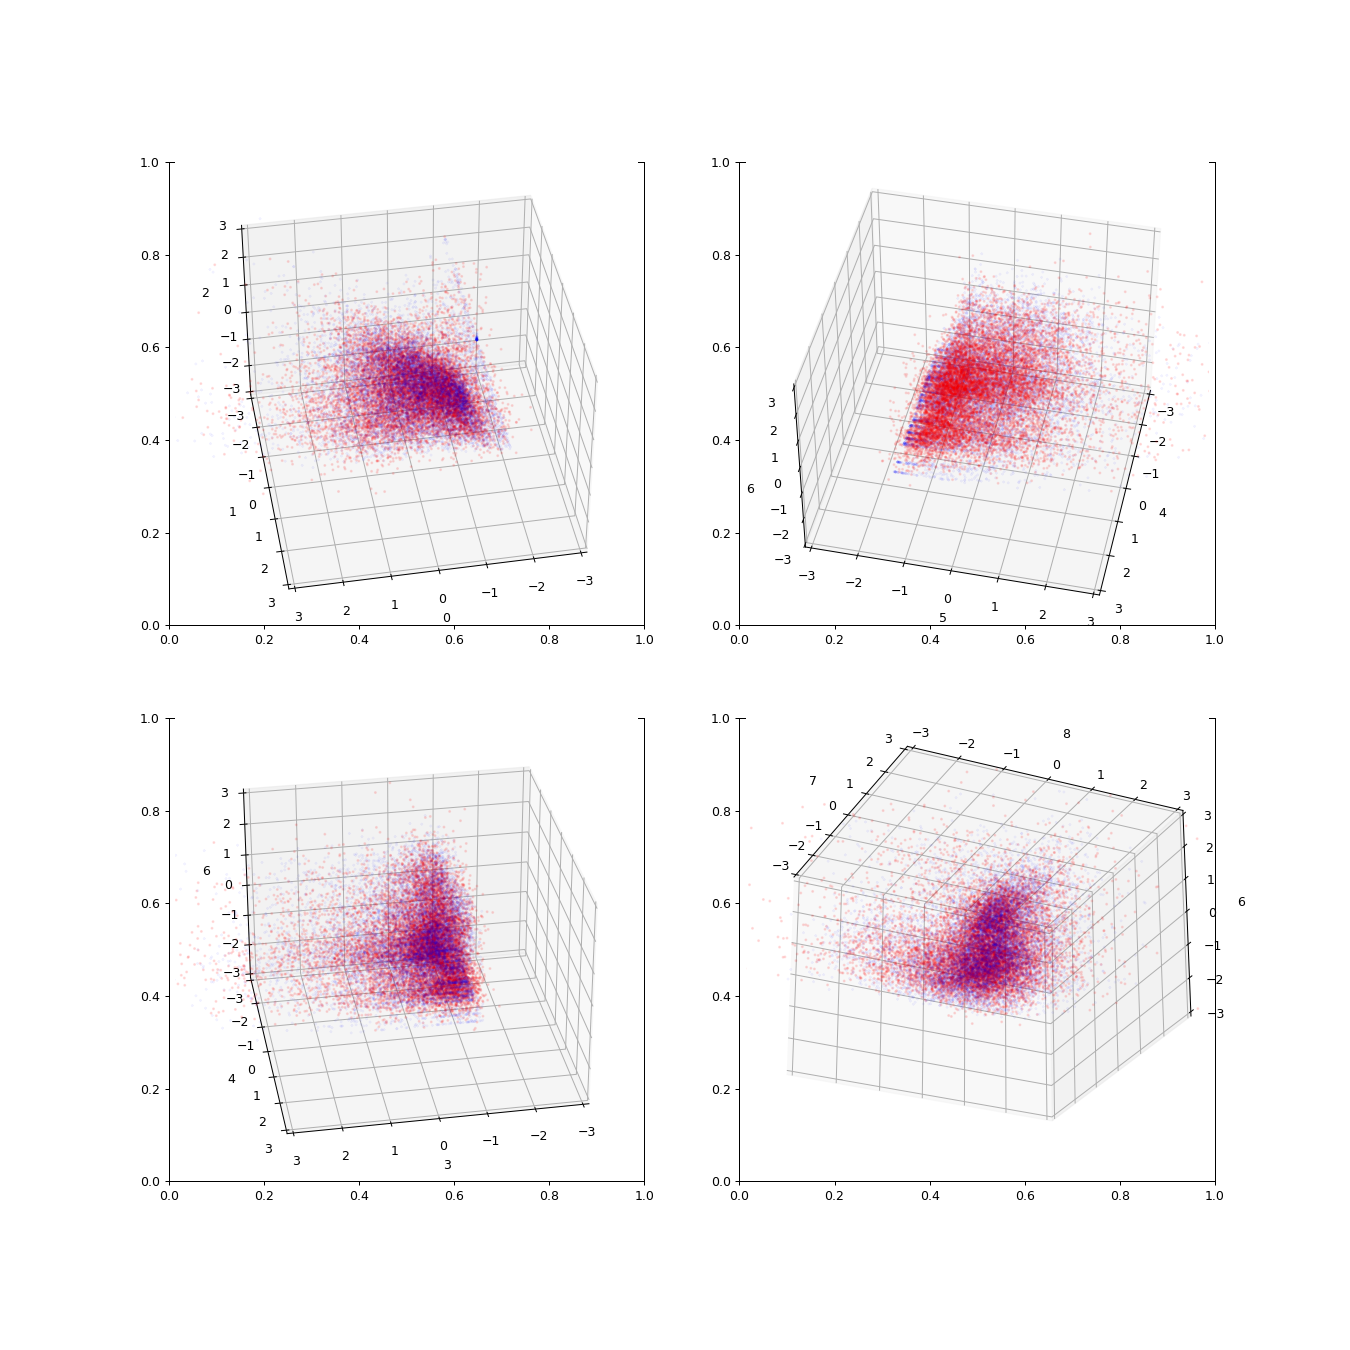

<IPython.core.display.Javascript object>


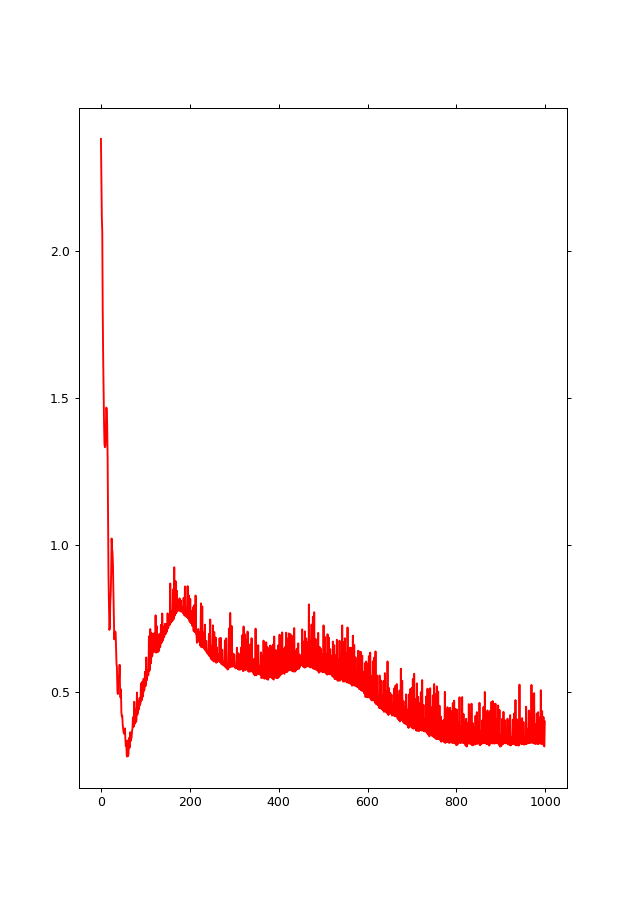

Train Epoch: 0 [0/11031 (0%)]	Loss_D: 1.386514	Loss_G: 1.228263
KL-divergence =  2.380159378051758
Train Epoch: 1 [0/11031 (0%)]	Loss_D: 1.385477	Loss_G: 3.346282
KL-divergence =  2.232830762863159
Train Epoch: 2 [0/11031 (0%)]	Loss_D: 1.384001	Loss_G: 1.406063
KL-divergence =  2.1114602088928223
Train Epoch: 3 [0/11031 (0%)]	Loss_D: 1.383608	Loss_G: 2.310892
KL-divergence =  2.0637450218200684
Train Epoch: 4 [0/11031 (0%)]	Loss_D: 1.381139	Loss_G: 1.766151
KL-divergence =  1.7978886365890503
Train Epoch: 5 [0/11031 (0%)]	Loss_D: 1.379249	Loss_G: 4.445522
KL-divergence =  1.6403796672821045
Train Epoch: 6 [0/11031 (0%)]	Loss_D: 1.379848	Loss_G: 1.955826
KL-divergence =  1.5269614458084106
Train Epoch: 7 [0/11031 (0%)]	Loss_D: 1.378213	Loss_G: 1.352518
KL-divergence =  1.4089384078979492
Train Epoch: 8 [0/11031 (0%)]	Loss_D: 1.381852	Loss_G: 1.879038
KL-divergence =  1.3402981758117676
Train Epoch: 9 [0/11031 (0%)]	Loss_D: 1.382793	Loss_G: 1.691476
KL-divergence =  1.3314707279205322
Tr

KL-divergence =  0.4974866807460785
Train Epoch: 82 [0/11031 (0%)]	Loss_D: 1.345908	Loss_G: 2.455954
KL-divergence =  0.4222525656223297
Train Epoch: 83 [0/11031 (0%)]	Loss_D: 1.327326	Loss_G: 1.752787
KL-divergence =  0.4311295747756958
Train Epoch: 84 [0/11031 (0%)]	Loss_D: 1.366288	Loss_G: 1.110338
KL-divergence =  0.4673265814781189
Train Epoch: 85 [0/11031 (0%)]	Loss_D: 1.369008	Loss_G: 2.378612
KL-divergence =  0.43968287110328674
Train Epoch: 86 [0/11031 (0%)]	Loss_D: 1.334051	Loss_G: 1.329448
KL-divergence =  0.44329291582107544
Train Epoch: 87 [0/11031 (0%)]	Loss_D: 1.324408	Loss_G: 3.023735
KL-divergence =  0.47914552688598633
Train Epoch: 88 [0/11031 (0%)]	Loss_D: 1.340878	Loss_G: 1.303952
KL-divergence =  0.4553375244140625
Train Epoch: 89 [0/11031 (0%)]	Loss_D: 1.366209	Loss_G: 1.729169
KL-divergence =  0.4605712592601776
Train Epoch: 90 [0/11031 (0%)]	Loss_D: 1.355849	Loss_G: 1.591436
KL-divergence =  0.5283083915710449
Train Epoch: 91 [0/11031 (0%)]	Loss_D: 1.340194	Loss

KL-divergence =  0.8479104042053223
Train Epoch: 163 [0/11031 (0%)]	Loss_D: 1.347661	Loss_G: 1.627858
KL-divergence =  0.7456551790237427
Train Epoch: 164 [0/11031 (0%)]	Loss_D: 1.311587	Loss_G: 1.269575
KL-divergence =  0.750950813293457
Train Epoch: 165 [0/11031 (0%)]	Loss_D: 1.262735	Loss_G: 1.746472
KL-divergence =  0.923417329788208
Train Epoch: 166 [0/11031 (0%)]	Loss_D: 1.231131	Loss_G: 2.893847
KL-divergence =  0.7584866285324097
Train Epoch: 167 [0/11031 (0%)]	Loss_D: 1.319854	Loss_G: 2.231985
KL-divergence =  0.7610573172569275
Train Epoch: 168 [0/11031 (0%)]	Loss_D: 1.320326	Loss_G: 2.020564
KL-divergence =  0.8762696385383606
Train Epoch: 169 [0/11031 (0%)]	Loss_D: 1.292998	Loss_G: 2.128906
KL-divergence =  0.766804039478302
Train Epoch: 170 [0/11031 (0%)]	Loss_D: 1.301002	Loss_G: 1.678453
KL-divergence =  0.7691972255706787
Train Epoch: 171 [0/11031 (0%)]	Loss_D: 1.264895	Loss_G: 1.324680
KL-divergence =  0.8434151411056519
Train Epoch: 172 [0/11031 (0%)]	Loss_D: 1.398677	

KL-divergence =  0.6968064904212952
Train Epoch: 244 [0/11031 (0%)]	Loss_D: 1.276102	Loss_G: 2.258468
KL-divergence =  0.6218349933624268
Train Epoch: 245 [0/11031 (0%)]	Loss_D: 1.278353	Loss_G: 2.402020
KL-divergence =  0.6204783916473389
Train Epoch: 246 [0/11031 (0%)]	Loss_D: 1.234607	Loss_G: 1.922697
KL-divergence =  0.7458637356758118
Train Epoch: 247 [0/11031 (0%)]	Loss_D: 1.277650	Loss_G: 1.810773
KL-divergence =  0.6130142211914062
Train Epoch: 248 [0/11031 (0%)]	Loss_D: 1.309566	Loss_G: 2.275760
KL-divergence =  0.6117015480995178
Train Epoch: 249 [0/11031 (0%)]	Loss_D: 1.205665	Loss_G: 3.106465
KL-divergence =  0.6563324928283691
Train Epoch: 250 [0/11031 (0%)]	Loss_D: 1.205879	Loss_G: 2.191267
KL-divergence =  0.6082757711410522
Train Epoch: 251 [0/11031 (0%)]	Loss_D: 1.264817	Loss_G: 1.547929
KL-divergence =  0.6116145849227905
Train Epoch: 252 [0/11031 (0%)]	Loss_D: 1.281946	Loss_G: 2.210917
KL-divergence =  0.7259759306907654
Train Epoch: 253 [0/11031 (0%)]	Loss_D: 1.2585

KL-divergence =  0.6953478455543518
Train Epoch: 325 [0/11031 (0%)]	Loss_D: 1.252477	Loss_G: 4.593426
KL-divergence =  0.5755354166030884
Train Epoch: 326 [0/11031 (0%)]	Loss_D: 1.294459	Loss_G: 1.492042
KL-divergence =  0.574698805809021
Train Epoch: 327 [0/11031 (0%)]	Loss_D: 1.092811	Loss_G: 2.625432
KL-divergence =  0.6770266890525818
Train Epoch: 328 [0/11031 (0%)]	Loss_D: 1.276513	Loss_G: 2.032008
KL-divergence =  0.578805685043335
Train Epoch: 329 [0/11031 (0%)]	Loss_D: 1.258249	Loss_G: 2.755728
KL-divergence =  0.5760326385498047
Train Epoch: 330 [0/11031 (0%)]	Loss_D: 1.233106	Loss_G: 1.827822
KL-divergence =  0.7048137187957764
Train Epoch: 331 [0/11031 (0%)]	Loss_D: 1.358005	Loss_G: 1.624375
KL-divergence =  0.5736536383628845
Train Epoch: 332 [0/11031 (0%)]	Loss_D: 1.206355	Loss_G: 2.207868
KL-divergence =  0.568597674369812
Train Epoch: 333 [0/11031 (0%)]	Loss_D: 1.248996	Loss_G: 3.147071
KL-divergence =  0.6303567886352539
Train Epoch: 334 [0/11031 (0%)]	Loss_D: 1.189037	

KL-divergence =  0.6412293910980225
Train Epoch: 406 [0/11031 (0%)]	Loss_D: 1.286109	Loss_G: 2.214887
KL-divergence =  0.5607625842094421
Train Epoch: 407 [0/11031 (0%)]	Loss_D: 1.188725	Loss_G: 3.746580
KL-divergence =  0.5595218539237976
Train Epoch: 408 [0/11031 (0%)]	Loss_D: 1.234724	Loss_G: 2.544057
KL-divergence =  0.701969563961029
Train Epoch: 409 [0/11031 (0%)]	Loss_D: 1.330686	Loss_G: 1.881912
KL-divergence =  0.5670772790908813
Train Epoch: 410 [0/11031 (0%)]	Loss_D: 1.348350	Loss_G: 1.662005
KL-divergence =  0.5659402012825012
Train Epoch: 411 [0/11031 (0%)]	Loss_D: 1.273471	Loss_G: 2.223071
KL-divergence =  0.6448847055435181
Train Epoch: 412 [0/11031 (0%)]	Loss_D: 1.324537	Loss_G: 2.624482
KL-divergence =  0.5652929544448853
Train Epoch: 413 [0/11031 (0%)]	Loss_D: 1.269542	Loss_G: 1.788719
KL-divergence =  0.5607656240463257
Train Epoch: 414 [0/11031 (0%)]	Loss_D: 1.209573	Loss_G: 1.486646
KL-divergence =  0.651955246925354
Train Epoch: 415 [0/11031 (0%)]	Loss_D: 1.298792

KL-divergence =  0.6397004127502441
Train Epoch: 487 [0/11031 (0%)]	Loss_D: 1.308921	Loss_G: 1.082598
KL-divergence =  0.5731500387191772
Train Epoch: 488 [0/11031 (0%)]	Loss_D: 1.283242	Loss_G: 1.566507
KL-divergence =  0.5716987252235413
Train Epoch: 489 [0/11031 (0%)]	Loss_D: 1.304876	Loss_G: 1.359021
KL-divergence =  0.7004032731056213
Train Epoch: 490 [0/11031 (0%)]	Loss_D: 1.207217	Loss_G: 2.052642
KL-divergence =  0.5666193962097168
Train Epoch: 491 [0/11031 (0%)]	Loss_D: 1.256319	Loss_G: 1.716790
KL-divergence =  0.5648360848426819
Train Epoch: 492 [0/11031 (0%)]	Loss_D: 1.201948	Loss_G: 3.213012
KL-divergence =  0.6528064608573914
Train Epoch: 493 [0/11031 (0%)]	Loss_D: 1.292431	Loss_G: 2.601983
KL-divergence =  0.5686280131340027
Train Epoch: 494 [0/11031 (0%)]	Loss_D: 1.303169	Loss_G: 3.301597
KL-divergence =  0.568901538848877
Train Epoch: 495 [0/11031 (0%)]	Loss_D: 1.296025	Loss_G: 1.709717
KL-divergence =  0.6459882259368896
Train Epoch: 496 [0/11031 (0%)]	Loss_D: 1.28066

KL-divergence =  0.690788745880127
Train Epoch: 568 [0/11031 (0%)]	Loss_D: 1.259297	Loss_G: 1.529971
KL-divergence =  0.5239052176475525
Train Epoch: 569 [0/11031 (0%)]	Loss_D: 1.260044	Loss_G: 2.271068
KL-divergence =  0.5253462791442871
Train Epoch: 570 [0/11031 (0%)]	Loss_D: 1.176320	Loss_G: 1.754138
KL-divergence =  0.6592581868171692
Train Epoch: 571 [0/11031 (0%)]	Loss_D: 1.173360	Loss_G: 3.063779
KL-divergence =  0.5205885171890259
Train Epoch: 572 [0/11031 (0%)]	Loss_D: 1.348101	Loss_G: 2.140734
KL-divergence =  0.5224384069442749
Train Epoch: 573 [0/11031 (0%)]	Loss_D: 1.408786	Loss_G: 1.978771
KL-divergence =  0.6172962784767151
Train Epoch: 574 [0/11031 (0%)]	Loss_D: 1.351087	Loss_G: 1.357432
KL-divergence =  0.5229490995407104
Train Epoch: 575 [0/11031 (0%)]	Loss_D: 1.234175	Loss_G: 3.409644
KL-divergence =  0.5182990431785583
Train Epoch: 576 [0/11031 (0%)]	Loss_D: 1.231307	Loss_G: 4.662474
KL-divergence =  0.575484037399292
Train Epoch: 577 [0/11031 (0%)]	Loss_D: 1.342644

KL-divergence =  0.5131123065948486
Train Epoch: 649 [0/11031 (0%)]	Loss_D: 1.241116	Loss_G: 2.244695
KL-divergence =  0.42765000462532043
Train Epoch: 650 [0/11031 (0%)]	Loss_D: 1.266955	Loss_G: 1.611264
KL-divergence =  0.42531082034111023
Train Epoch: 651 [0/11031 (0%)]	Loss_D: 1.201341	Loss_G: 1.624603
KL-divergence =  0.4963085353374481
Train Epoch: 652 [0/11031 (0%)]	Loss_D: 1.240859	Loss_G: 1.489957
KL-divergence =  0.4264358580112457
Train Epoch: 653 [0/11031 (0%)]	Loss_D: 1.206485	Loss_G: 1.587022
KL-divergence =  0.4261942207813263
Train Epoch: 654 [0/11031 (0%)]	Loss_D: 1.169546	Loss_G: 2.913494
KL-divergence =  0.49030864238739014
Train Epoch: 655 [0/11031 (0%)]	Loss_D: 1.245859	Loss_G: 1.690773
KL-divergence =  0.41923391819000244
Train Epoch: 656 [0/11031 (0%)]	Loss_D: 1.283517	Loss_G: 2.415247
KL-divergence =  0.42025890946388245
Train Epoch: 657 [0/11031 (0%)]	Loss_D: 1.232385	Loss_G: 1.966813
KL-divergence =  0.4590397775173187
Train Epoch: 658 [0/11031 (0%)]	Loss_D: 1

KL-divergence =  0.4050081670284271
Train Epoch: 730 [0/11031 (0%)]	Loss_D: 1.246348	Loss_G: 1.429966
KL-divergence =  0.36657366156578064
Train Epoch: 731 [0/11031 (0%)]	Loss_D: 1.192701	Loss_G: 3.454190
KL-divergence =  0.3657006025314331
Train Epoch: 732 [0/11031 (0%)]	Loss_D: 1.224819	Loss_G: 2.190970
KL-divergence =  0.4839652180671692
Train Epoch: 733 [0/11031 (0%)]	Loss_D: 1.211969	Loss_G: 1.499826
KL-divergence =  0.36008554697036743
Train Epoch: 734 [0/11031 (0%)]	Loss_D: 1.283568	Loss_G: 2.285532
KL-divergence =  0.36033570766448975
Train Epoch: 735 [0/11031 (0%)]	Loss_D: 1.258987	Loss_G: 1.468634
KL-divergence =  0.5105512738227844
Train Epoch: 736 [0/11031 (0%)]	Loss_D: 1.325745	Loss_G: 3.070672
KL-divergence =  0.35481148958206177
Train Epoch: 737 [0/11031 (0%)]	Loss_D: 1.230303	Loss_G: 1.469484
KL-divergence =  0.35403239727020264
Train Epoch: 738 [0/11031 (0%)]	Loss_D: 1.245304	Loss_G: 5.950406
KL-divergence =  0.5069180727005005
Train Epoch: 739 [0/11031 (0%)]	Loss_D: 1

KL-divergence =  0.38266581296920776
Train Epoch: 811 [0/11031 (0%)]	Loss_D: 1.255838	Loss_G: 2.126399
KL-divergence =  0.32705384492874146
Train Epoch: 812 [0/11031 (0%)]	Loss_D: 1.227348	Loss_G: 2.319051
KL-divergence =  0.3287114202976227
Train Epoch: 813 [0/11031 (0%)]	Loss_D: 1.147369	Loss_G: 3.003331
KL-divergence =  0.4821057915687561
Train Epoch: 814 [0/11031 (0%)]	Loss_D: 1.330461	Loss_G: 1.385492
KL-divergence =  0.32691290974617004
Train Epoch: 815 [0/11031 (0%)]	Loss_D: 1.277237	Loss_G: 1.644369
KL-divergence =  0.32595983147621155
Train Epoch: 816 [0/11031 (0%)]	Loss_D: 1.254213	Loss_G: 3.365583
KL-divergence =  0.42447158694267273
Train Epoch: 817 [0/11031 (0%)]	Loss_D: 1.266111	Loss_G: 2.268934
KL-divergence =  0.32523012161254883
Train Epoch: 818 [0/11031 (0%)]	Loss_D: 1.244638	Loss_G: 2.612391
KL-divergence =  0.32651710510253906
Train Epoch: 819 [0/11031 (0%)]	Loss_D: 1.157431	Loss_G: 3.154585
KL-divergence =  0.3971013128757477
Train Epoch: 820 [0/11031 (0%)]	Loss_D:

KL-divergence =  0.3252156674861908
Train Epoch: 891 [0/11031 (0%)]	Loss_D: 1.259873	Loss_G: 1.927547
KL-divergence =  0.4076510965824127
Train Epoch: 892 [0/11031 (0%)]	Loss_D: 1.199465	Loss_G: 1.514725
KL-divergence =  0.3261595368385315
Train Epoch: 893 [0/11031 (0%)]	Loss_D: 1.188189	Loss_G: 10.165027
KL-divergence =  0.32559746503829956
Train Epoch: 894 [0/11031 (0%)]	Loss_D: 1.179002	Loss_G: 1.707629
KL-divergence =  0.45357319712638855
Train Epoch: 895 [0/11031 (0%)]	Loss_D: 1.164196	Loss_G: 1.911622
KL-divergence =  0.32170426845550537
Train Epoch: 896 [0/11031 (0%)]	Loss_D: 1.190507	Loss_G: 2.781235
KL-divergence =  0.31894806027412415
Train Epoch: 897 [0/11031 (0%)]	Loss_D: 1.227249	Loss_G: 2.209676
KL-divergence =  0.43810757994651794
Train Epoch: 898 [0/11031 (0%)]	Loss_D: 1.267346	Loss_G: 1.592236
KL-divergence =  0.31346988677978516
Train Epoch: 899 [0/11031 (0%)]	Loss_D: 1.196623	Loss_G: 1.927996
KL-divergence =  0.31460806727409363
Train Epoch: 900 [0/11031 (0%)]	Loss_D

KL-divergence =  0.3266194760799408
Train Epoch: 972 [0/11031 (0%)]	Loss_D: 1.226910	Loss_G: 2.855529
KL-divergence =  0.4916634261608124
Train Epoch: 973 [0/11031 (0%)]	Loss_D: 1.206262	Loss_G: 2.867230
KL-divergence =  0.32724446058273315
Train Epoch: 974 [0/11031 (0%)]	Loss_D: 1.147910	Loss_G: 1.824901
KL-divergence =  0.3258279860019684
Train Epoch: 975 [0/11031 (0%)]	Loss_D: 1.248305	Loss_G: 1.963548
KL-divergence =  0.4954265356063843
Train Epoch: 976 [0/11031 (0%)]	Loss_D: 1.232185	Loss_G: 4.343653
KL-divergence =  0.3234420716762543
Train Epoch: 977 [0/11031 (0%)]	Loss_D: 1.271180	Loss_G: 2.419859
KL-divergence =  0.32335004210472107
Train Epoch: 978 [0/11031 (0%)]	Loss_D: 1.195730	Loss_G: 2.939641
KL-divergence =  0.3908202648162842
Train Epoch: 979 [0/11031 (0%)]	Loss_D: 1.187430	Loss_G: 3.170982
KL-divergence =  0.3232721984386444
Train Epoch: 980 [0/11031 (0%)]	Loss_D: 1.240288	Loss_G: 1.600567
KL-divergence =  0.324612557888031
Train Epoch: 981 [0/11031 (0%)]	Loss_D: 1.193

In [21]:
%matplotlib notebook


# optimizer_D = optim.Adam(D.parameters(), lr=1e-7, weight_decay=1e-9)
# optimizer_G = optim.Adam(G.parameters(), lr=1e-6, weight_decay=1e-9)
# optimizer_D = optim.Adam(D.parameters(), lr=1e-6)
# optimizer_G = optim.Adam(G.parameters(), lr=5e-6)


if __name__ == "__main__":

    # point distribution figure
#     fig = plt.figure(figsize=[10, 10])
    fig, ax = plt.subplots(2, 2, figsize=[15, 15])
    for i in range(2):
        for j in range(2):
            ax[i, j] = fig.add_subplot(2, 2, i*2+j+1, projection='3d')
#             ax[i, j].set(projection='3d')

    ax[1,0].view_init(elev=30., azim=80)
    ax[1,1].view_init(elev=30., azim=60)
    ax[0,0].view_init(elev=40., azim=80)
    ax[0,1].view_init(elev=40., azim=60)      
    
    # KL-divergence figure
    maxEpoch = 1000
    
    fig_KL, ax_KL = plt.subplots(1, 1, figsize=[7, 10])
    kl_array = np.zeros(maxEpoch)
    kl_array[:] = np.nan
    
    
    for epoch in range(0, maxEpoch):
        train(epoch)
#         if epoch % 10 == 0:
#             torch.save(G, './models_k9/G' + str(epoch))
            
#             torch.save(D, './models_k9/D' + str(epoch))
        
        if epoch % 3 == 0:
            plot_trainData_and_syntheticData(ax)
            plt.title('epoch: %i ' %epoch )
            fig.canvas.draw()
        
        # print KL-divergence
        if epoch % 1 == 0:
            synthetic_data = G(ginput).detach()
            KLD = KLdivergence(synthetic_data, train_dataset[:,2:], k=10)
            print("KL-divergence = ", KLD.item())
            
            kl_array[epoch] = KLD.item()
            ax_KL.clear()
            ax_KL.plot(np.arange(0, maxEpoch), kl_array, 'r')
            fig_KL.canvas.draw()
            

In [22]:
# torch.save(G, './models_k9/G_final_1115')
# torch.save(D, './models_k9/D_fina_1115')

In [23]:
###### loading models
# remark: model classes should be defined

# G2 = torch.load('./models/G_final')
# D2 = torch.load('./models/D_final')


In [24]:
# G2

In [25]:
# G = torch.load('./models/GG_final')
# D = torch.load('./models/DD_final')
# G = torch.load('./models/GG_final_')
# D = torch.load('./models/DD_final_')
# G = torch.load('./models/GGG_final_')
# D = torch.load('./models/DDD_final_')
# G = torch.load('./models/GG9999')
# D = torch.load('./models/DD9999')

In [26]:
# G

In [27]:
## Histogram

In [28]:
# # normalize 하는법 
# def solvex(x,u,s):
#     output = ((x-u)/s)
#     return output

# #  denormalization
# def invsolve(x,u,s):
#     element = (x*s)+u
#     return element 

In [29]:
# # ## 원하는 data만 plot하기 위해서 
# raw2 = torch.tensor([6.0])
# raw3 = torch.tensor([37.0])

# ph825 = list()
# train_data = dataset.cpu()

# env_np = torch.from_numpy(env_map2)

# 
x = solvex(raw2,env_np[0,0],env_np[0,1])
# y = solvex(raw3,env_np[1,0],env_np[1,1])
# n_input = torch.cat([x, y] ,dim=0)

# for entry in train_data:
#     if entry[0] == x and entry[1] == y:
#          ph825.append(entry[2:].reshape(1,10))      
# ph825 = torch.cat(ph825, dim=0)
# ph825 = ph825.numpy()
# for j in range (0,ph825.shape[1]):
#     for i in range(0,ph825.shape[0]): 
#         ph825[i,j] = invsolve(ph825[i,j],env_np[j+2,0],env_np[j+2,1])

NameError: name 'raw2' is not defined

In [ ]:
# ### new input?? 
# env_np = torch.from_numpy(env_map2)

# x = solvex(raw2,env_np[0,0],env_np[0,1])
# y = solvex(raw3,env_np[1,0],env_np[1,1])

# n_input = torch.cat([x, y] ,dim=0)

# idx = dataset.size(0)
# new_input = n_input.repeat(idx,1)
# ginput_test =torch.cat([new_input,torch.randn(idx,100)],dim=1).float().to(device)

# # ginput_test
# ginput_test

In [ ]:
# synthetic_data = G(ginput_test).detach().cpu()
# synthetic_data_denormalized = synthetic_data.clone()

# for j in range (0,synthetic_data_denormalized.shape[1]):
#     synthetic_data_denormalized[:,j] = invsolve(synthetic_data_denormalized[:,j],env_np[j+2,0],env_np[j+2,1])
    
# synthetic_data_denormalized = synthetic_data_denormalized.numpy()    

In [ ]:
# import seaborn as sns

# plt.figure()
# sns.kdeplot(ph825[:,4], bw=0.5, bw_adjust=.1, cut=0, label = 'real data', linewidth=3)
# sns.kdeplot(synthetic_data_denormalized[:,4], bw=0.5, bw_adjust=.1, cut=0, label = 'synthetic data', linewidth=3)
# plt.draw()
# plt.legend()

# plt.figure()
# sns.kdeplot(ph825[:,8], bw=0.5, bw_adjust=.1, cut=0, label = 'real data', linewidth=3)
# sns.kdeplot(synthetic_data_denormalized[:,8], bw=0.5, bw_adjust=.1, cut=0, label = 'synthetic data', linewidth=3)
# plt.draw()
# plt.legend()
    

In [ ]:
# ph825[:, [4,8]].mean(axis=0)

In [ ]:
# synthetic_data_denormalized[:, [4,8]].mean(axis=0)